In [1]:
!mamba env create --quiet -f environment.yml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK

done
Installing pip dependencies: ...working... done


In [ ]:
!conda env create --quiet -f https://raw.githubusercontent.com/Denolle-Lab/seisbench-jupyter/main/environment.yml

In [1]:
import obspy
import obsplus
import pandas as pd
from obspy.clients.fdsn import Client
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
import seisbench
import seisbench.models as sbm
import dask
import json
import alaska_utils

# Progress bar for dask operations:
from dask.diagnostics import ProgressBar
pbar = dask.diagnostics.ProgressBar()
pbar.register()

## 1. Download waveforms

In [2]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

In [139]:
# Download waveforms

waveform_length = 60
waveform_overlap = 20
t1 = datetime.datetime(2018,5,25,12,35)
t1 = datetime.datetime(2019,5,27,9,52,30)
t2 = t1 + pd.Timedelta(3,'minutes')
time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(waveform_length-waveform_overlap,'seconds')))

@dask.delayed
def loop_times(dfS,t1,waveform_length):
    return alaska_utils.retrieve_waveforms(dfS,t1,t1+pd.Timedelta(waveform_length,'seconds'),separate=True)

lazy_results = [loop_times(dfS,time,waveform_length) for time in time_bins]

In [85]:
results = dask.compute(lazy_results)

[########################################] | 100% Completed |  1min 53.6s


In [86]:
# Concat into big list of streams
test = sum(results,[])
stream = []
for t in test:
    stream.extend(t)

## 2. Denoise

In [87]:
%%time
model = sbm.DeepDenoiser.from_pretrained("original")

CPU times: user 27.4 ms, sys: 4.09 ms, total: 31.5 ms
Wall time: 29.4 ms


In [88]:
%%time
denoise = np.empty([len(stream)],dtype=object)
for i,st in enumerate(stream):
    den = model.annotate(st)
    denoise[i]=den

CPU times: user 1min 27s, sys: 4.14 s, total: 1min 31s
Wall time: 39.7 s


## 3. Phase pick

In [89]:
model = sbm.EQTransformer.from_pretrained("original")

# EDIT MODEL TO NOT CUT SAMPLES OFF 
model.default_args["blinding"] = (0,0)

In [90]:
%%time
annotation = np.empty([len(denoise)],dtype=object)
pick = np.empty([len(denoise)],dtype=object)
detection = np.empty([len(denoise)],dtype=object)
for i,st in enumerate(denoise):
    at = model.annotate(st)
    # pks, dets = model.classify(st)
    annotation[i]=at; # pick[i]=pks; detection[i]=dets;
    
# Note: still need to figure out why this error is thrown, but it is thrown here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L623
# and here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L548

2022-02-10 19:44:20,660 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-10 19:44:29,305 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-10 19:44:39,716 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-10 19:44:48,932 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-10 19:44:49,214 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-10 19:45:07,483 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


CPU times: user 1min 59s, sys: 414 ms, total: 1min 59s
Wall time: 56.4 s


Notes about the "Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty" warning:

For t1 = datetime.datetime(2019,5,27,9,52,30), the warning is thrown on XO.LT12, though only on the first two minutes.
For t1 = datetime.datetime(2018,5,25,12,35), for the first minute, the warning is thrown on XO.LA32. For the next two minutes, it is thrown on XO.LA29.

I caught these by printing out the IDs of the traces for the raw data and the annotated data and visually comparing to see which one is missing- see below. Which is odd... since when you loop through the traces individually and print out their IDs to see which one the error is thrown on, the error is either thrown before or after the missing trace, which makes me think that there's an indexing problem.

It doesn't seem to have anything to do with overlap. The reason those overlaps were appearing was only because we had merged the streams together using this loop:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
If you look at the stream produced by this loop, many stations have overlaps between the 60 s traces. It is not what is causing the issue.
The individual streams that the model.annotate() function is performed on do not have overlaps. This can be checked using stream.print_gaps()

I cannot for the life of me find anything that is different about the traces that the warning is thrown on... to be continued! I need to dig into the source code more.


In [63]:
stream[55]

3 Trace(s) in Stream:
XO.LT12..HH1 | 2019-05-27T09:52:30.000600Z - 2019-05-27T09:53:29.990600Z | 100.0 Hz, 6000 samples
XO.LT12..HH2 | 2019-05-27T09:52:29.993500Z - 2019-05-27T09:53:29.983500Z | 100.0 Hz, 6000 samples
XO.LT12..HHZ | 2019-05-27T09:52:30.002400Z - 2019-05-27T09:53:29.992400Z | 100.0 Hz, 6000 samples

In [72]:
test = seisbench.models.base.WaveformModel()
ar = test.stream_to_arrays(stream[2])
for t in ar[1][0]:
    print(len(t))
# seisbench.models.base.WaveformModel.stream_to_arrays(test,stream[0])

6001
6001
6001


In [69]:
test = seisbench.models.base.WaveformModel()
ar = test.stream_to_arrays(stream[55])
for t in ar[1][0]:
    print(len(t))

5999
5999
5999


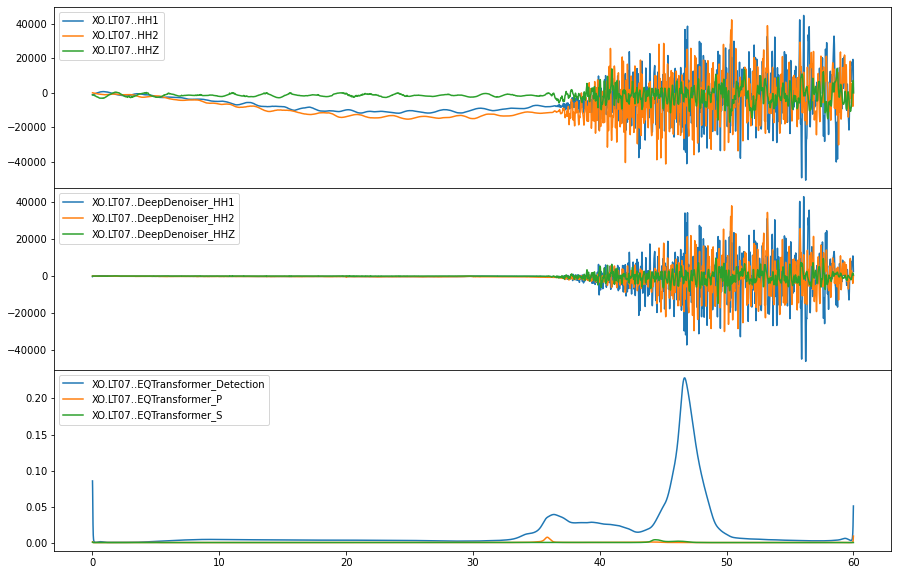

In [104]:
# GUT CHECK

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotation[0][0].stats.starttime - denoise[0][0].stats.starttime
i=50 # 5, 50
# example of where a P and S wave come in separately in 60 s windows and are faultily picked - 188 and 287
for j in [0,1,2]:
    axs[0].plot(stream[i][j].times(), stream[i][j].data, label=stream[i][j].id) 
    axs[1].plot(denoise[i][j].times(), denoise[i][j].data, label=denoise[i][j].id)
    axs[2].plot(annotation[i][j].times() + offset, annotation[i][j].data, label=annotation[i][j].id)

axs[0].legend()
axs[1].legend()
axs[2].legend()

#v axs[0].set_xlim([6,8])

## 4. Extract and save picks

Note: some annotated streams are 5999 samples, others are 6000

In [94]:
import postprocess

preds = np.empty([1,6001,1,3])
raw = np.empty([1,6000,1,3])
dat = np.empty([1,6000,1,3])
station_ids = []
t0 = []
match_idx = []
gamma_picks = [];pick_meta=[];
empty = []
for i in range(int(len(annotation))):
    
    # For empty annotations:
    if not annotation[i]:
        empty.append(stream[i][0].id)
        continue
    
    # For short traces:
    if annotation[i][0].stats.npts < preds.shape[1]:
        preds[0,:,0,0] = np.append(annotation[i][0].data,[0])
        preds[0,:,0,1] = np.append(annotation[i][1].data,[0])
        preds[0,:,0,2] = np.append(annotation[i][2].data,[0])
    # For traces of correct length:
    else:
        preds[0,:,0,0] = annotation[i][0].data
        preds[0,:,0,1] = annotation[i][1].data
        preds[0,:,0,2] = annotation[i][2].data
    
    station_id = annotation[i][0].stats.network + '..' + annotation[i][0].stats.station + '.'
    final_id = stream[i][0].stats.network + '.' + stream[i][0].stats.station + '..' + stream[i][0].stats.channel[0:2]
    station_ids.append(station_id)
    t0.append(str(annotation[i][0].stats.starttime))
    
    
    picks = postprocess.extract_picks(preds,station_ids = [station_id],fnames = [station_id],t0=[str(annotation[i][0].stats.starttime)])
    
    # now call to original data using the same i index to get amplitudes
    
    # Raw amplitudes
    raw[0,:,0,0] = stream[i].select(channel="**Z")[0].data[0:6000]
    if stream[i].select(channel="**N"):
        raw[0,:,0,1] = stream[i].select(channel="**N")[0].data[0:6000]
        raw[0,:,0,2] = stream[i].select(channel="**E")[0].data[0:6000]
    else:
        raw[0,:,0,1] = stream[i].select(channel="**1")[0].data[0:6000]
        raw[0,:,0,2] = stream[i].select(channel="**2")[0].data[0:6000]
    raw_amps = postprocess.extract_amplitude(raw,picks)
    
    # Denoised amplitudes
    dat[0,:,0,0] = denoise[i].select(channel="**Z")[0].data[0:6000]
    if stream[i].select(channel="**N"):
        dat[0,:,0,1] = denoise[i].select(channel="**N")[0].data[0:6000]
        dat[0,:,0,2] = denoise[i].select(channel="**E")[0].data[0:6000]
    else:
        dat[0,:,0,1] = denoise[i].select(channel="**1")[0].data[0:6000]
        dat[0,:,0,2] = denoise[i].select(channel="**2")[0].data[0:6000]
    den_amps = postprocess.extract_amplitude(dat,picks)

    # Then, if the pick isn't empty, calculate SNR of pick
    if picks[0].p_prob[0]:
        for j in range(len(picks[0].p_prob[0])):
            # Get timestamp of pick:
            ts = annotation[i][0].stats.starttime + (pd.Timedelta(1,'seconds')*annotation[i][0].stats.delta*picks[0].p_idx[0][j])
            # Get SNR of pick:
            z_raw_snr = calc_snr(stream[i].select(channel="**Z")[0],picks[0].p_idx[0][j],'P');
            z_den_snr = calc_snr(denoise[i].select(channel="**Z")[0],picks[0].p_idx[0][j],'P');
            if stream[i].select(channel="**N"):
                n_raw_snr = calc_snr(stream[i].select(channel="**N")[0],picks[0].p_idx[0][j],'P');
                e_raw_snr = calc_snr(stream[i].select(channel="**E")[0],picks[0].p_idx[0][j],'P');
                n_den_snr = calc_snr(denoise[i].select(channel="**N")[0],picks[0].p_idx[0][j],'P');
                e_den_snr = calc_snr(denoise[i].select(channel="**E")[0],picks[0].p_idx[0][j],'P');
            else:
                n_raw_snr = calc_snr(stream[i].select(channel="**1")[0],picks[0].p_idx[0][j],'P');
                e_raw_snr = calc_snr(stream[i].select(channel="**2")[0],picks[0].p_idx[0][j],'P');
                n_den_snr = calc_snr(denoise[i].select(channel="**1")[0],picks[0].p_idx[0][j],'P');
                e_den_snr = calc_snr(denoise[i].select(channel="**2")[0],picks[0].p_idx[0][j],'P');
            # Save all info in dictionary:
            p_dict = {'id':final_id,'network':stream[i][0].stats.network,'station':stream[i][0].stats.station,'channel':stream[i][0].stats.channel[0:2],'phase':'P',\
                      'timestamp':ts,'prob':picks[0].p_prob[0][j],'raw_amp':raw_amps[0].p_amp[0][j],'den_amp':den_amps[0].p_amp[0][j],\
                      'z_raw_snr':z_raw_snr,'z_den_snr':z_den_snr,'n_raw_snr':n_raw_snr,'n_den_snr':n_den_snr,'e_raw_snr':e_raw_snr,'e_den_snr':e_den_snr}
            pick_meta.append(p_dict)
    if picks[0].s_prob[0]:
        for j in range(len(picks[0].s_prob[0])):
            # Get timestamp of pick:
            ts = annotation[i][0].stats.starttime + (pd.Timedelta(1,'seconds')*annotation[i][0].stats.delta*picks[0].s_idx[0][j])
            # Get SNR of pick:
            z_raw_snr = calc_snr(stream[i].select(channel="**Z")[0],picks[0].s_idx[0][j],'S');
            z_den_snr = calc_snr(denoise[i].select(channel="**Z")[0],picks[0].s_idx[0][j],'S');
            if stream[i].select(channel="**N"):
                n_raw_snr = calc_snr(stream[i].select(channel="**N")[0],picks[0].s_idx[0][j],'S');
                e_raw_snr = calc_snr(stream[i].select(channel="**E")[0],picks[0].s_idx[0][j],'S');
                n_den_snr = calc_snr(denoise[i].select(channel="**N")[0],picks[0].s_idx[0][j],'S');
                e_den_snr = calc_snr(denoise[i].select(channel="**E")[0],picks[0].s_idx[0][j],'S');
            else:
                n_raw_snr = calc_snr(stream[i].select(channel="**1")[0],picks[0].s_idx[0][j],'S');
                e_raw_snr = calc_snr(stream[i].select(channel="**2")[0],picks[0].s_idx[0][j],'S');
                n_den_snr = calc_snr(denoise[i].select(channel="**1")[0],picks[0].s_idx[0][j],'S');
                e_den_snr = calc_snr(denoise[i].select(channel="**2")[0],picks[0].s_idx[0][j],'S');
            # Save all info in dictionary:
            s_dict = {'id':final_id,'network':stream[i][0].stats.network,'station':stream[i][0].stats.station,'channel':stream[i][0].stats.channel[0:2],'phase':'S',\
                      'timestamp':ts,'prob':picks[0].s_prob[0][j],'raw_amp':raw_amps[0].s_amp[0][j],'den_amp':den_amps[0].s_amp[0][j],\
                      'z_raw_snr':z_raw_snr,'z_den_snr':z_den_snr,'n_raw_snr':n_raw_snr,'n_den_snr':n_den_snr,'e_raw_snr':e_raw_snr,'e_den_snr':e_den_snr}
            pick_meta.append(s_dict)

# Save all pick info as pandas dataframe
pick_info = pd.DataFrame.from_dict(pick_meta)
gamma_picks = convert_to_gamma(pick_info)  

/tmp/ipykernel_1283/921918399.py:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))
/srv/conda/envs/alaska-ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/alaska-ml/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [129]:
def convert_to_gamma(pick_df):
    gamma_picks = []
    for i in range(len(pick_df)):
        p = pick_df.iloc[i]
        gamma_dict = {'id':p['id'],'timestamp':str(p['timestamp']),'prob':p['prob'],'amp':p['raw_amp'],'type':p['phase']}
        gamma_picks.append(gamma_dict)
    return gamma_picks
        